In [13]:
import os

import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shap


In [7]:

base_model = joblib.load('./Data/gridSearch_rf.pickle')
balanced_model = joblib.load('./Data/gridSearch_rf_balanced.pickle')
imbalanced_model = joblib.load('./Data/gridSearch_rf_imbalanced.pickle')

best_models: dict = {"base": base_model.best_estimator_, "balanced": balanced_model.best_estimator_, "imbalanced": imbalanced_model.best_estimator_}

best_models

{'base': Pipeline(steps=[('ct',
                  ColumnTransformer(transformers=[('num', StandardScaler(),
                                                   ['IUCR', 'Domestic', 'Beat',
                                                    'District', 'Ward',
                                                    'Community Area', 'FBI Code',
                                                    'Latitude', 'Longitude']),
                                                  ('desc', TargetEncoder(),
                                                   ['Description',
                                                    'Location Description']),
                                                  ('date', StandardScaler(),
                                                   ['Date'])])),
                 ('clf',
                  RandomForestClassifier(max_depth=6, n_estimators=1000))]),
 'balanced': Pipeline(steps=[('ct',
                  ColumnTransformer(transformers=[('num', StandardScaler(),
  

In [6]:
X_test = pd.read_pickle('Data/X_test.pickle')
X_test


,Date,IUCR,Description,Location Description,Domestic,Beat,District,Ward,Community Area,FBI Code,Latitude,Longitude
206927,2022-10-13 08:24:00,530,AGGRAVATED - OTHER DANGEROUS WEAPON,SMALL RETAIL STORE,0,234,2,4.0,41,4,41.799463,-87.596008
216364,2022-12-06 06:30:00,810,OVER $500,STREET,0,1215,12,1.0,24,6,41.893434,-87.661256
16342,2022-02-03 14:00:00,1310,TO PROPERTY,OTHER (SPECIFY),0,212,2,3.0,35,14,41.828596,-87.621710
139666,2022-08-23 21:30:00,1506,SOLICIT ON PUBLIC WAY,STREET,0,1131,11,24.0,25,16,41.868820,-87.741269
169041,2022-11-12 23:00:00,910,AUTOMOBILE,STREET,0,211,2,4.0,35,7,41.834691,-87.613706
...,...,...,...,...,...,...,...,...,...,...,...,...
29570,2022-01-11 19:32:00,560,SIMPLE,STREET,0,915,9,11.0,60,8,41.828648,-87.648256
125549,2022-04-22 12:13:00,890,FROM BUILDING,APARTMENT,0,114,1,42.0,32,6,41.884791,-87.624469
57670,2022-05-22 16:00:00,560,SIMPLE,CTA BUS,0,124,1,25.0,28,8,41.874367,-87.642789
113862,2022-06-19 09:00:00,610,FORCIBLE ENTRY,APARTMENT,0,1114,11,28.0,26,5,41.885804,-87.731792


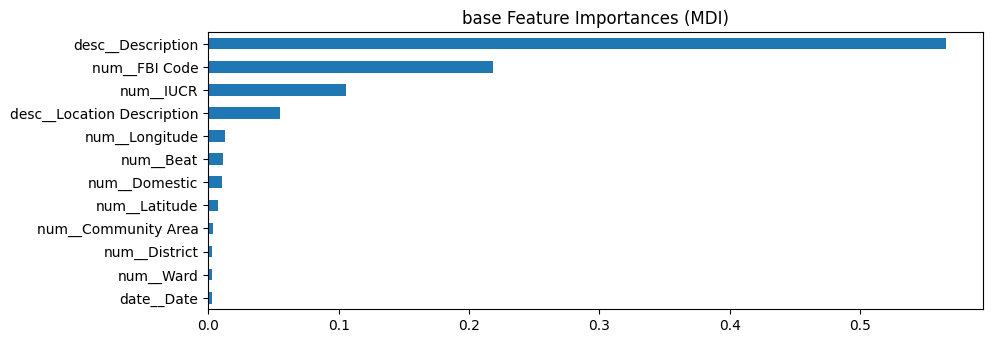

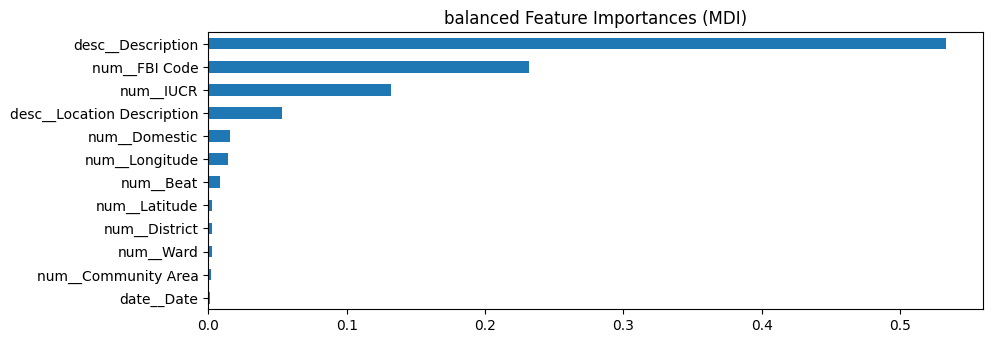

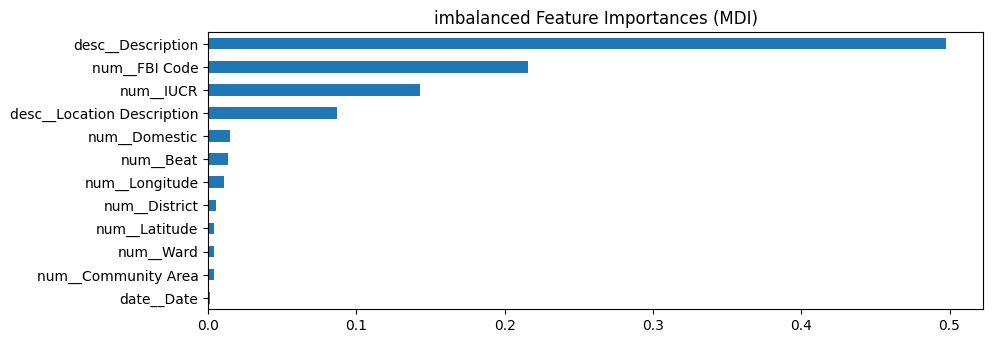

In [9]:
for key, best_model in best_models.items():
    model=best_model.named_steps['clf']
    if hasattr(best_model.named_steps['ct'], 'get_feature_names_out'):
        feature_names = best_model.named_steps['ct'].get_feature_names_out()
    else:
        feature_names = best_model.named_steps['ct'].get_feature_names()
    # Get the transformed feature names
    mdi_importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=True)

    # Set figure size to increase spacing
    plt.figure(figsize=(10, len(mdi_importances) * 0.3))  # Adjust the height based on the number of features

    # Plot the importances
    ax = mdi_importances.plot.barh()
    ax.set_title(f"{key} Feature Importances (MDI)")

    # Optionally, you can increase the font size for y-axis labels
    ax.tick_params(axis='y', labelsize=10)  # Adjust labelsize for readability
    plt.savefig(f'Graphs/{key}_feature_importance.jpg', format='jpeg', dpi=300, bbox_inches ='tight')
    plt.show()

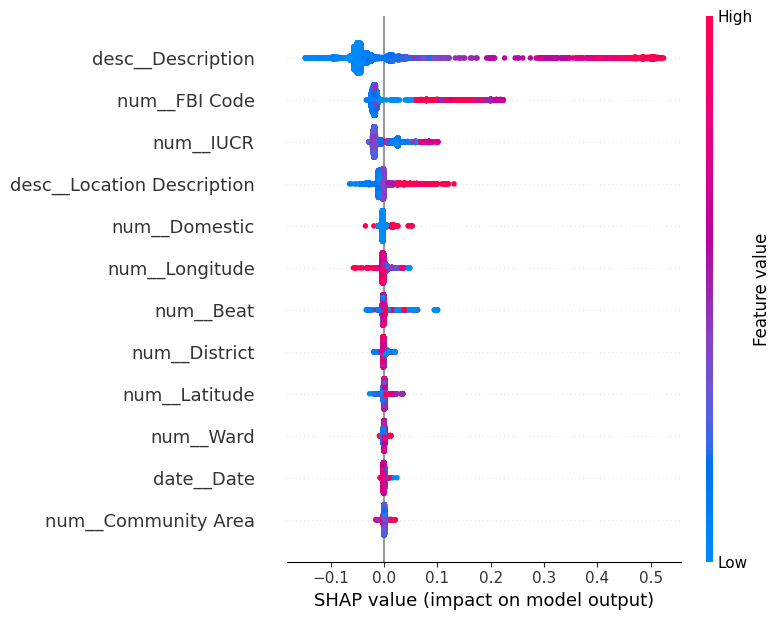

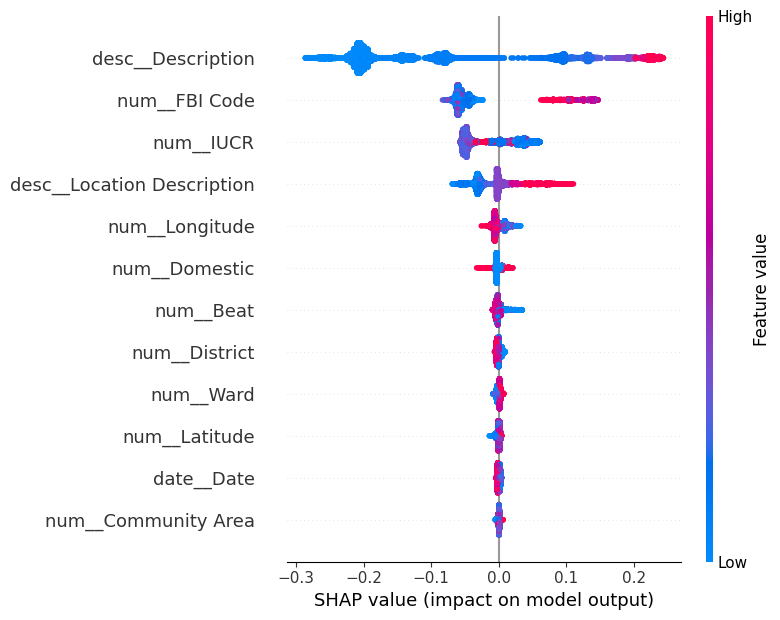

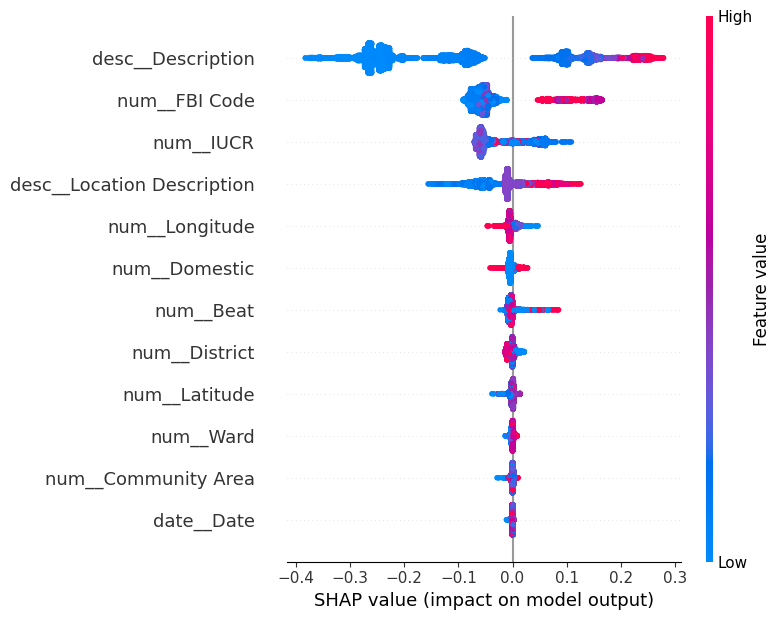

In [ ]:
for key, best_model in best_models.items():
    if hasattr(best_model.named_steps['ct'], 'get_feature_names_out'):
        feature_names = best_model.named_steps['ct'].get_feature_names_out()
    else:
        feature_names = best_model.named_steps['ct'].get_feature_names()
    model=best_model.named_steps['clf']
    x_val_transformed = best_model.named_steps['ct'].transform(X_test)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_val_transformed)
    shap.summary_plot(shap_values[:,:,1,], x_val_transformed, feature_names=feature_names, show=False)
    plt.savefig(f'Graphs/{key}_shap_impact.jpg', format='jpeg', dpi=300, bbox_inches ='tight')
    plt.show()

In [ ]:
# shap.dependence_plot('Alm', shap_values[:,:,1], x_val_transformed_name)
for key, best_model in best_models.items():
    if hasattr(best_model.named_steps['ct'], 'get_feature_names_out'):
        feature_names = best_model.named_steps['ct'].get_feature_names_out()
    else:
        feature_names = best_model.named_steps['ct'].get_feature_names()
    model=best_model.named_steps['clf']
    x_val_transformed_name = pd.DataFrame(best_model.named_steps['ct'].transform(X_test), columns=feature_names)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_val_transformed_name)

    # Create directory for saving plots
    output_dir = f'Graphs/{key}_shap_dependence'
    os.makedirs(output_dir, exist_ok=True)
    
    for feature in feature_names:
        plt.figure()  # Explicitly create a new figure
        shap.dependence_plot(feature, shap_values[:,:,1], x_val_transformed_name, show=False)
        plt.savefig(f'{output_dir}/{feature}.jpg', format='jpeg', dpi=300, bbox_inches ='tight')
        # plt.show()
        plt.close()  # Close the plot to free up memory

    

In [8]:
shap.initjs()